In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git
# !rm -r kagglehub_cache/

# !pip install -U kagglehub

Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 261 (delta 108), reused 230 (delta 77), pack-reused 0 (from 0)
Receiving objects: 100% (261/261), 4.23 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import sys
from pathlib import Path
from collections import Counter
from peft import LoraConfig, get_peft_model
import os

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.evaluation.confusion import plot_confusion_matrix
from src.evaluation.metrics import classification_metrics
from transformers import HubertModel
from src.datasets.urban_sound_8k import UrbanDataset

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from src.methods.finetuning.training import train_model
from src.methods.finetuning.inference import get_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
data_root = "/kaggle/input/urbansound8k"

dataset = UrbanDataset(data_root)

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))

Using Colab cache for faster access to the 'urbansound8k' dataset.
Classes : ['fold1', 'fold10', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']
Nombre total de fichiers : 8732


In [65]:
labels = [label for _, label in dataset.data]
indices = list(range(len(dataset)))
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

temp_labels = [labels[i] for i in temp_idx]


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


In [66]:
train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=16,
    shuffle=False
)

test_loader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=16,
    shuffle=False
)


In [67]:
print("Train:", Counter([labels[i] for i in train_idx]))
print("Val:  ", Counter([labels[i] for i in val_idx]))
print("Test: ", Counter([labels[i] for i in test_idx]))


Train: Counter({4: 693, 5: 655, 3: 647, 2: 622, 0: 611, 7: 587, 1: 586, 6: 576, 9: 571, 8: 564})
Val:   Counter({4: 149, 5: 140, 3: 139, 2: 133, 0: 131, 1: 126, 7: 125, 9: 123, 6: 123, 8: 121})
Test:  Counter({4: 148, 5: 141, 3: 139, 2: 133, 0: 131, 7: 126, 1: 125, 6: 124, 9: 122, 8: 121})


In [68]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [69]:
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.2,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

In [70]:
hubert = get_peft_model(hubert, lora_config)
hubert.print_trainable_parameters()

trainable params: 147,456 || all params: 94,519,168 || trainable%: 0.1560


In [71]:
class HubertLoRAClassifier(nn.Module):
    def __init__(self, hubert, num_classes):
        super().__init__()
        self.hubert = hubert
        self.classifier = nn.Linear(
            hubert.config.hidden_size,
            num_classes
        )

    def forward(self, x):
        out = self.hubert.base_model(input_values=x)
        h = out.last_hidden_state
        z = h.mean(dim=1)
        return self.classifier(z)


In [72]:
model = HubertLoRAClassifier(hubert, num_classes=len(dataset.classes))
model.to(device)

HubertLoRAClassifier(
  (hubert): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): HubertModel(
        (feature_extractor): HubertFeatureEncoder(
          (conv_layers): ModuleList(
            (0): HubertGroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1-4): 4 x HubertNoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (5-6): 2 x HubertNoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
          )
        )
        (feature_projection): HubertFeatureProjection(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=Tr

In [73]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

In [74]:
history = train_model(model,train_loader, val_loader, optimizer=optimizer, criterion=criterion, n_epochs=10, device=device)


Epoch 1/10


Epoch 1 | Train loss 2.2989 | Train acc 0.108 | Val acc 0.118
✓ Saved checkpoint (val acc = 0.118)

Epoch 2/10


Epoch 2 | Train loss 2.2861 | Train acc 0.129 | Val acc 0.124
✓ Saved checkpoint (val acc = 0.124)

Epoch 3/10


Epoch 3 | Train loss 2.2732 | Train acc 0.142 | Val acc 0.139
✓ Saved checkpoint (val acc = 0.139)

Epoch 4/10


Epoch 4 | Train loss 2.2522 | Train acc 0.162 | Val acc 0.157
✓ Saved checkpoint (val acc = 0.157)

Epoch 5/10


Epoch 5 | Train loss 2.2365 | Train acc 0.177 | Val acc 0.153
✓ Saved checkpoint (val acc = 0.153)

Epoch 6/10


Epoch 6 | Train loss 2.2161 | Train acc 0.189 | Val acc 0.137

Epoch 7/10


Epoch 7 | Train loss 2.1944 | Train acc 0.205 | Val acc 0.164
✓ Saved checkpoint (val acc = 0.164)

Epoch 8/10


Epoch 8 | Train loss 2.1778 | Train acc 0.214 | Val acc 0.162
✓ Saved checkpoint (val acc = 0.162)

Epoch 9/10


Epoch 9 | Train loss 2.1593 | Train acc 0.229 | Val acc 0.129

Epoch 10/10


Epoch 10 | Train loss 2.1419 | Train acc 0.237 | Val acc 0.134


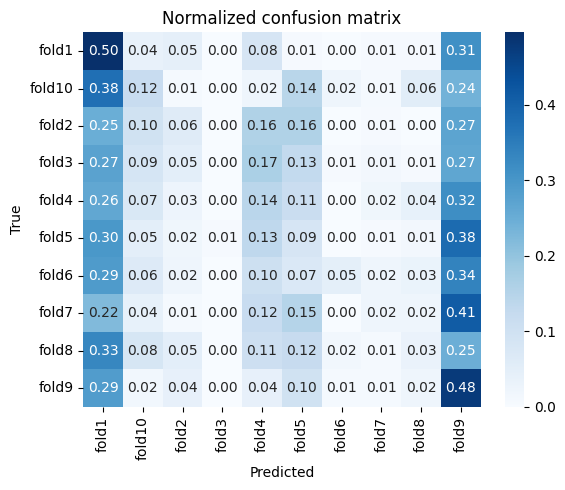

In [75]:
y_true, y_pred = get_predictions(model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, class_names=dataset.classes)


In [76]:
classification_metrics(y_pred=y_pred, y_true=y_true)

{'accuracy': 0.1465648854961832,
 'f1_macro': 0.10968016359359338,
 'precision_macro': 0.16467761150115195,
 'recall_macro': 0.14839961648062955}